# Определение стоимости автомобилей

## Введение

В данном проекте мы решим задачу в рамках темы "Численные методы", по проекту "Определение стоимости автомобилей".

Ниже можно найти описание задачи, а также примерный план проекта.

<b>Описание задачи:</b>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>План работы над проектом:</b>
- Изучение общей информации о файле с данными.
- Изучение столбцов и проверка данных.
- Обучение моделей.
- Изучение моделей и выбор оптимальной.
- Общий вывод.
- Чек-лист проекта.

<b>Автор проекта:</b>
- Виктория Кускова, 
- студентка Яндекс.Практикума, 2021.


## Подготовка данных

### Общая информация

Выделим импорты всех библиотек, импорт файла с данными и общую информацию по нему в отдельные ячейки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
#импорт файла с данными
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.shape

(354369, 16)

Итого, у нас 354369 строк и 16 столбцов. Один из столбцов целевой - Price. 

Видим, что у всех столбцов тип целые числа или объект. 

Также видим, что есть пропуски в следующих 5 столбцах:
- VehicleType - 37490 пропусков, это около 10% строк;
- Gearbox - 19833 пропусков, около 5% строк;
- Model - 19705 пропусков, около 5% строк;
- FuelType - 32895, около 10%;
- NotRepaired - 71154, около 20%.

Все эти признаки с типом object. Возможно причины возникновения пропусков связаны с этим, к примеру это могло быть из-за:
- Неполнота списка вариантов для выбора. И когда пользователь или сотрудник вносят данные по автомобилю, то могут не найти нужного варианта и пропустить заполнение этого поля.
- Незнание пользователем или сотрудником значение технического поля и вариантов ответа, поэтому они могут пропустить заполнение этого шага.
- Вариант ответа (один из объектов) подбирается уже после заполнения анкеты, и из-за ошибок в заполении -вариант не подбирается автоматически.
- Эти данные собираются в одну таблицу тянутся из разных систем, и где-то могут быть не полные справочники, или не совпадающие друг с другом, устаревшие на каком-то этапе, поэтому данные теряются при передаче и сборе данных.
- Сам пропуск может означать отдельный тип. К примеру, если машина не была ремонтирована, то возможно пропуск это и означает.

Посмотрим далее на эти столбцы и поймем нужно ли заменять эти пропуски, или модели лучше и обучить на данных с пропусками. Ведь, к примеру, если у пользователей были проблемы с заполнением определенных полей и они их пропускли, то они будут пропускать их и в будущем, и наша модель, обученная на данных без пропусков будет работать некорректно.

Посмотри еще на первые строки датасета.

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Видим, что в датасете есть признаки, которые характеризуют транспортное средство, но некоторые также характеризуют и пользователя (дата псоледней активности, индекс) или техинические (дата скачивания анкеты). Не все они необходимы для обучения модели. 

Дальше изучим столбцы подробнее, и решим какие признаки мы отберем для обучения.

### Изучения столбцов и проверка данных

#### Общие проверки

Для начала проверим есть ли дубликаты.

In [6]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Мы нашли строки, которые полностью дублируют друг друга. Несмотря на то, то у нас нет столбца четкого идентификатора пользавателя или объявления - у нас есть дата загрузки анкеты, месяц и год регистрации автомобиля, индекс и др. И вряд ли у нас нашлось бы у одного пользователя 2 абсолютно одинаковых автомобиля с идентичным пробегом. Или даже 2 разных пользователя, у которых оказались такие идентичные автосредства. Скорее всего это ошибка загрузки данных, запись попала дважды.

Удалим данные дубликаты.

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(354365, 16)

Дубликаты удалились.

Теперь посмотрим на столбцы DateCrawled - дата скачивания анкеты из базы, DateCreated — дата создания анкеты, PostalCode — почтовый индекс владельца анкеты (пользователя), LastSeen — дата последней активности пользователя. Все эти столбцы характеризуют скорее технические данные или личные данные пользователей.


In [9]:
df['DateCrawled'].min(), df['DateCrawled'].max()

('2016-03-05 14:06:22', '2016-04-07 14:36:58')

In [10]:
df['DateCreated'].min(), df['DateCreated'].max()

('2014-03-10 00:00:00', '2016-04-07 00:00:00')

In [11]:
df['PostalCode'].unique()

array([70435, 66954, 90480, ..., 38528, 38325, 31096])

In [12]:
df['LastSeen'].min(), df['LastSeen'].max()

('2016-03-05 14:15:08', '2016-04-07 14:58:51')

Действительно видим, что это технические поля. Скачивались анкеты в 2016 году, пользователи были активны также в 2016, а регистрировались с 2014 по 2016. Индексы разнообразные, была идея попробовать по ним идентифиццировать страну, но при первом же поиске примера индекса 70435, стало понятно что он повторяется в разных странах. Поэтому эта информация скорее бесполезная и мы не будем брать ее для обучения модели.

In [13]:
df.drop(columns=['DateCrawled','DateCreated','PostalCode','LastSeen'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 12 columns):
Price                354365 non-null int64
VehicleType          316875 non-null object
RegistrationYear     354365 non-null int64
Gearbox              334532 non-null object
Power                354365 non-null int64
Model                334660 non-null object
Kilometer            354365 non-null int64
RegistrationMonth    354365 non-null int64
FuelType             321470 non-null object
Brand                354365 non-null object
NotRepaired          283211 non-null object
NumberOfPictures     354365 non-null int64
dtypes: int64(6), object(6)
memory usage: 35.1+ MB


#### Числовые столбцы

Теперь посмотрим на числовые столбцы. Посмотрим на их характеристики и графики распределения.

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354365.0,4416.679830,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354365.0,110.093816,189.851330,0.0,69.0,105.0,143.0,20000.0
Kilometer,354365.0,128211.363989,37905.083858,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354365.0,5.714650,3.726432,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354365.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Сразу видим, что столбец с <b>количеством фотографий</b> оказался бесполезный. В нем все значения равны 0. 

Его тоже нужно будет удалить.

In [15]:
df.drop(columns=['NumberOfPictures'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
Price                354365 non-null int64
VehicleType          316875 non-null object
RegistrationYear     354365 non-null int64
Gearbox              334532 non-null object
Power                354365 non-null int64
Model                334660 non-null object
Kilometer            354365 non-null int64
RegistrationMonth    354365 non-null int64
FuelType             321470 non-null object
Brand                354365 non-null object
NotRepaired          283211 non-null object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


Также столбец с <b>месяцем регистрации</b> выглядит простым и без ошибок. Посмотри на распределение значений.

In [16]:
df['RegistrationMonth'].value_counts()

0     37352
3     34373
6     31507
4     29270
5     29153
7     27211
10    26099
12    24289
11    24186
9     23813
1     23218
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

Видим, что все-таки есть значение, где он не указан. Вероятно люди, заполняя анкету, не всегда помнят его. Это большая часть данных - около 10%. Оставим его как есть, вероятно при использовании приложения в будущем. Такие ситуации будут повторяться и нам нужно будет предсказывать цену и в таких случаях тоже.

Теперь посмотрим на <b>Цену</b>, целевой признак.

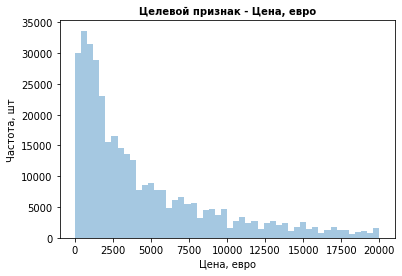

In [17]:
plt.title("Целевой признак - Цена, евро", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df['Price'], kde=False, rug=False, axlabel="Цена, евро")
plt.show()

У целевого признака нет неожиданных выбросов и необычных значений, это хорошо. Видно, что чем дороже объявление, тем таких объявлений меньше. Это правдоподобно. Посмотрим также отдельно на пик около 0.

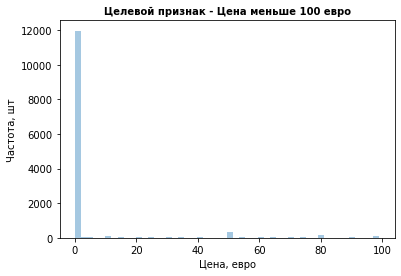

In [18]:
plt.title("Целевой признак - Цена меньше 100 евро", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df.query('Price < 100')['Price'], kde=False, rug=False, axlabel="Цена, евро")
plt.show()

In [19]:
df[df['Price'] == 0].count()

Price                10772
VehicleType           7032
RegistrationYear     10772
Gearbox               8294
Power                10772
Model                 8588
Kilometer            10772
RegistrationMonth    10772
FuelType              7336
Brand                10772
NotRepaired           5484
dtype: int64

In [20]:
df[df['Price'] == 0].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes


Видим, что нулевых значений много, но при этом параметры машины не выглядят так, что владелец готов отдать ее бесплатно. Возможно эти значения как раз появились из-за того, что он не понимает какую цену ставить и оставляет 0, чтобы посмотреть что ему предложат покупатели.

Принашем работающем приложении и модели такие ситуации уменьшатся, так как мы по умолчанию будем предлагать цену.

Для обучения же модели уберем эти данные.

In [21]:
df.drop(df[df['Price'] == 0].index, inplace=True)

Если смотреть на следующий признак - <b>Год регистрации</b>, то из таблицы с характеристиками видим в минимуме и максимуме неправдоподобные значения - 1000 и 9999. 

Очевидно, что раз данные мы выгружали в 2016 году, то года больше 2016 - это ошибки. Автомобиль изобрели в 1886, а первое производство автомобилей было основано в 1888. Это возможно, что люди могут продавать раритетные машины, но машины выпущенные до 1888 года - это явно ошибка. Посмотрим на эти строки. И распределение остальных данных без них.

In [22]:
df.query('RegistrationYear > 2016 or RegistrationYear < 1888').count()

Price                13832
VehicleType             19
RegistrationYear     13832
Gearbox              12079
Power                13832
Model                11948
Kilometer            13832
RegistrationMonth    13832
FuelType              8548
Brand                13832
NotRepaired           7848
dtype: int64

In [23]:
df.query('RegistrationYear > 2016 or RegistrationYear < 1888')['RegistrationYear'].unique()

array([2018, 2017, 5000, 3200, 1000, 9999, 8888, 1500, 2200, 4100, 3000,
       2066, 2019, 1800, 1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911,
       1400, 4000, 8500, 1255, 3700, 3800, 4800, 7000, 6500, 2290, 1001,
       9450, 2500, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 4500,
       1602, 7800, 7100, 8200])

Тут явно выделяются значение 2017 и 2018. Эти года, которые находятся на временной прямой рядом. Остальные же года больше походят на ошибки, а не реальные года. посмотрим на количества значений по этим ошибкам.

In [24]:
df.query('RegistrationYear > 2016 or RegistrationYear < 1888')['RegistrationYear'].value_counts()

2017    9895
2018    3782
1000      31
9999      18
2019      16
5000      16
3000       6
6000       5
1800       5
1234       4
7000       4
2500       3
4000       3
1500       3
1600       2
4500       2
8000       2
5911       2
9000       2
1300       2
5555       2
3800       1
3200       1
5600       1
2800       1
4800       1
2200       1
1400       1
1001       1
1255       1
1602       1
2066       1
1039       1
7100       1
6500       1
2222       1
5900       1
9450       1
5300       1
4100       1
3700       1
2900       1
8888       1
8200       1
7800       1
1111       1
2290       1
8500       1
Name: RegistrationYear, dtype: int64

Действительно ошибка с 2017 и 2018 сильно распространенна. А другие не очень. Вероятно с 2000 годами люди случайно ошибались. Важно, что для корректной работы модели и приложения в будущем мы не сможем при таких ошибках предсказывать цену правильно. Поэтому необходимо не допустить вводить такие данные. Необходимо будет поставть заглушку на ввод неправильных значений. К примеру, выдавать ошибку при вводе года до 1888 и после текущего года.


А теперь удалим неправдаподобные значения.

In [25]:
df.drop(df[df['RegistrationYear'] > 2016].index, inplace=True)
df.drop(df[df['RegistrationYear'] < 1888].index, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329761 entries, 0 to 354368
Data columns (total 11 columns):
Price                329761 non-null int64
VehicleType          309824 non-null object
RegistrationYear     329761 non-null int64
Gearbox              314159 non-null object
Power                329761 non-null int64
Model                314124 non-null object
Kilometer            329761 non-null int64
RegistrationMonth    329761 non-null int64
FuelType             305586 non-null object
Brand                329761 non-null object
NotRepaired          269879 non-null object
dtypes: int64(5), object(6)
memory usage: 30.2+ MB


Посмотрим на оставщиеся данные с корректным годом 1888 - 2016.

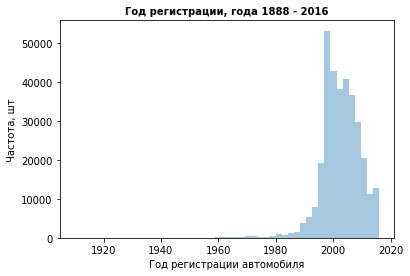

In [27]:
plt.title("Год регистрации, года 1888 - 2016", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df.query(
    'RegistrationYear <= 2016 and RegistrationYear >= 1888'
)['RegistrationYear'], kde=False, rug=False, axlabel="Год регистрации автомобиля")
plt.show()

Теперь данные выглядят правдоподобно. 

Посмотрим на <b>Пробег</b>.

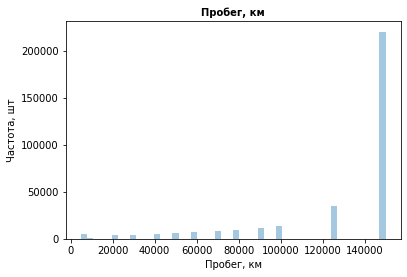

In [28]:
plt.title("Пробег, км", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df['Kilometer'], kde=False, rug=False, axlabel="Пробег, км")
plt.show()

Видим, что значения распределены только в нескольких точках. Скорее всего это примерный пробег и было всего несколько вариантов выбора этого показателя. Проверим это ниже. Но распределение это выглядит правдоподобно, так как у большинства поддержанных машин большой пробег.

In [29]:
df['Kilometer'].value_counts()

150000    220503
125000     34410
100000     14007
90000      11036
80000       9612
70000       8270
60000       7213
50000       5991
5000        4973
40000       4763
30000       4221
20000       3688
10000       1074
Name: Kilometer, dtype: int64

Действительно, всего несколько примерных вариантов. Этот столбец оставляем как есть.

Теперь посмотрим на <b>Мощность</b>. По характеристикам видим, что есть аномальные большие значения. А именно, если проверить текущие достижения в машиностроении, то машины с мощностью более 1000 л.с. - сильная редкость. А средняя - около 100. Посмотрим на них в нашем наборе данных.

In [30]:
df.query('Power > 1000').count()

Price                262
VehicleType          245
RegistrationYear     262
Gearbox              251
Power                262
Model                234
Kilometer            262
RegistrationMonth    262
FuelType             220
Brand                262
NotRepaired          168
dtype: int64

Таких строк всего 302, посмотрим на распределение.

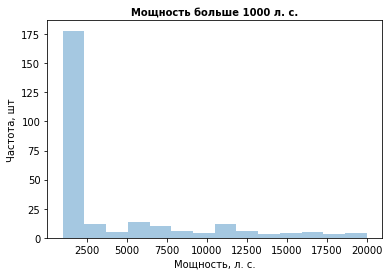

In [31]:
plt.title("Мощность больше 1000 л. с.", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df.query('Power >= 1000')['Power'], kde=False, rug=False, axlabel="Мощность, л. с.")
plt.show()

Возможно для некоторых случаев ошибка заключается в лишнем 0. Но мы также видим и значения около 200 тыс, у них ошибка заключается в другом. Так как таких случаев немного, то удалим их. Но для корректной работы приложения в будущем, необходимо установить заглушку-подсказку на ввод данного параметра. Нужно ограничить его максимальной мощностью.

In [32]:
df.drop(df[df['Power'] >= 1000].index, inplace=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329495 entries, 0 to 354368
Data columns (total 11 columns):
Price                329495 non-null int64
VehicleType          309575 non-null object
RegistrationYear     329495 non-null int64
Gearbox              313904 non-null object
Power                329495 non-null int64
Model                313886 non-null object
Kilometer            329495 non-null int64
RegistrationMonth    329495 non-null int64
FuelType             305363 non-null object
Brand                329495 non-null object
NotRepaired          269708 non-null object
dtypes: int64(5), object(6)
memory usage: 30.2+ MB


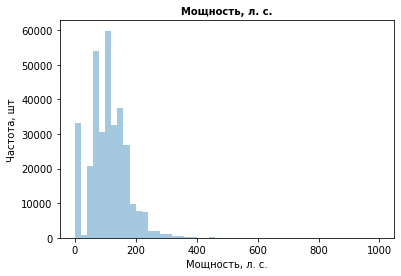

In [34]:
plt.title("Мощность, л. с.", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df['Power'], kde=False, rug=False, axlabel="Мощность, л. с.")
plt.show()

Мы видим, что опять же есть пик около 0. Но скорее всего опять же это значит, что пользователь это не указал. Необходимо исключить эту возможность на уровне приложения. Возможно поставив минимальную мощность. Или лучше ставить базовую среднюю мощность как вариант по умолчанию.

Посмотрим на данные около 0. И возможно заменим их на популярное значение.

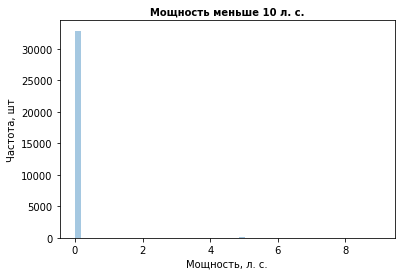

In [35]:
plt.title("Мощность меньше 10 л. с.", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df.query('Power < 10')['Power'], kde=False, rug=False, axlabel="Мощность, л. с.")
plt.show()

Давайте подумаем на что моожно заменить 0. Можно заменить это на среднее или медиану, к примеру. Также скорее всего мощность зависит от года регистарции. Как возможно и цена, наш целевой признак.

In [36]:
df['Power'].mean(), df['Power'].median()

(108.67455955325573, 105.0)

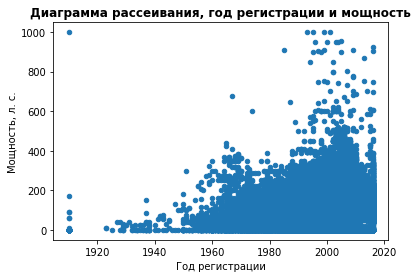

In [37]:
df.query('Power.notnull()').plot(
        x='RegistrationYear', y='Power', kind='scatter'
)  
plt.title("Диаграмма рассеивания, год регистрации и мощность", fontweight='bold', size='large')
plt.ylabel("Мощность, л. с.")
plt.xlabel("Год регистрации")
plt.show()

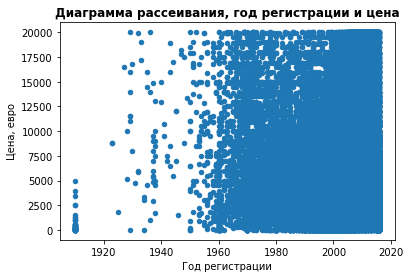

In [38]:
df.query('Price.notnull()').plot(
        x='RegistrationYear', y='Price', kind='scatter'
)  
plt.title("Диаграмма рассеивания, год регистрации и цена", fontweight='bold', size='large')
plt.ylabel("Цена, евро")
plt.xlabel("Год регистрации")
plt.show()

На первом графике зависимость от года видна больше, чем по цене. Хотя и по цене видно, что последние 10 лет более плотные.

Исходя из этого, давайте внедрим такой категориальный столбец "Retro":
- до 1970;
- от 1970 до 1990;
- от 1990 до 2000;
- от 2000 до 2005;
- от 2005 до 2010;
- от 2010

И посмотрим на медианы мощность по этим группам.

In [39]:
def retro_group(year):
    if year < 1970:
        return 'super-retro'
    elif year >= 1970 and year < 1990:
        return 'retro'
    elif year >= 1990 and year < 2000:
        return 'old'
    elif year >= 2000 and year < 2005:
        return 'dated'
    elif year >= 2005 and year < 2010:
        return 'middle'
    else:
        return 'new'
    
df['Retro'] = df['RegistrationYear'].apply(retro_group)
#df['Retro'] = df['Retro'].astype('category')

In [40]:
df['Retro'].value_counts()

dated          100196
old             88193
middle          87821
new             44423
retro            7743
super-retro      1119
Name: Retro, dtype: int64

Ретро классы предсталены меньше, но это нормально. Классы поддержанных машин последних лет имееют один порядок, хотя есть и лидеры. Оставим такое распределение.

Посмотрим на данные мощности медиан без 0 значений по группировки от ретрости машин, общая была - 105.

In [41]:
df.query('Power.notnull()').groupby(by='Retro')['Power'].median()

Retro
dated          105
middle         122
new            105
old             90
retro           75
super-retro     34
Name: Power, dtype: int64

У двух групп медиана совпала с общей, а так видно, что у ретро машин мощность меньше. А вот во второй половине нулевых выпускали больше можных машин. Заменим нули.

In [42]:
retro_groups = df['Retro'].unique()
power_median = 0

for text in retro_groups:
    power_median = df[df['Retro'] == text]['Power'].median()
    df.loc[(df['Power'] == 0)&(df['Retro'] == text), 'Power'] = power_median


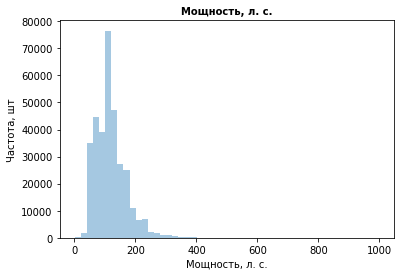

In [43]:
plt.title("Мощность, л. с.", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df['Power'], kde=False, rug=False, axlabel="Мощность, л. с.")
plt.show()

Пика в 0 по мощности больше нет. По числовым данным прошлись, теперь посмотри на категориальные.

#### Категориальные столбцы

Посмотрим на столбцы VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired. Во многих из них есть пропуски, как мы помним.

Также у нас появился новй столбец с группой ретрости машины. Но его мы уже изучили, и даже уже перевели в категориальный тип.

In [44]:
df['VehicleType'].value_counts()

sedan          89329
small          77959
wagon          63636
bus            28318
convertible    19853
coupe          15623
suv            11782
other           3075
Name: VehicleType, dtype: int64

In [45]:
df['Gearbox'].value_counts()

manual    250958
auto       62946
Name: Gearbox, dtype: int64

In [46]:
df['Model'].value_counts()

golf                  26722
other                 23169
3er                   18657
polo                  12021
corsa                 11586
                      ...  
kalina                    6
rangerover                3
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 250, dtype: int64

In [47]:
df['FuelType'].value_counts()

petrol      204559
gasoline     94783
lpg           5020
cng            531
hybrid         220
other          163
electric        87
Name: FuelType, dtype: int64

In [48]:
df['Brand'].value_counts()

volkswagen        70761
opel              36650
bmw               34734
mercedes_benz     30322
audi              27628
ford              23482
renault           16416
peugeot           10420
fiat               8871
seat               6354
skoda              5298
mazda              5254
smart              4962
citroen            4797
nissan             4615
toyota             4391
hyundai            3398
mini               3058
volvo              3053
mitsubishi         2813
sonstige_autos     2711
honda              2591
kia                2305
suzuki             2200
alfa_romeo         2155
chevrolet          1654
chrysler           1325
dacia               865
daihatsu            749
porsche             724
subaru              717
jeep                633
land_rover          526
daewoo              504
saab                504
jaguar              488
trabant             487
rover               437
lancia              436
lada                207
Name: Brand, dtype: int64

In [49]:
df['NotRepaired'].value_counts()

no     236781
yes     32927
Name: NotRepaired, dtype: int64

Также видим, что в данных столбцах есть самые популярные варианты часто, иногда есть значение others. Помня возможную природу пропусков, пропуски в данных значениях некорректно заполнять другими. Так как вероятно такие незаполненные данные будут опять встречаться в приложениях. Часто пользователи не знают или не помнят эту информацию, когда хотят узнать примерную цену через приложение. приравнивать к others тоже не верно, так как это именно уникальные значения, а не то, что неизвестно какие эти значения.

Заполним пропуски уникальным значением: None. Мы знаем, что некотрые библиотеки работают с признаками с пропусками, но не все, некоторые простые модели не могут их воспринимать. Поэтому сделаем это.

In [50]:
set = ['VehicleType', 'Gearbox', 'Model', 'Brand','FuelType', 'NotRepaired', 'Retro']

for text in set:
    df[text] = df[text].fillna('None')

Также видим, что почти для всех классов в столбцах значения встречаются часто, кроме столбца Модель. Там есть значения, где даже есть только 1 строка. При разбиении и дальнейшей оцифровизации признаков это может быть проблемой, так как эти значения могут попасть только в 1 из выборок. Оставим только значения с высокой частотой, а редкие заменим на other.

In [51]:
all_models = df['Model'].unique()

for text in all_models:
    if df[df['Model'] == text]['Model'].count() < 100:
        df.loc[df['Model'] == text, 'Model'] = 'other'    

In [52]:
df['Model'].value_counts()

golf         26722
other        25327
3er          18657
None         15609
polo         12021
             ...  
outlander      114
900            114
r19            111
aveo           110
antara         104
Name: Model, Length: 204, dtype: int64

Мы успешно убрали нечасто встречающиеся модели. Теперь переведем типы данных в категориальные.

In [53]:
for text in set:
    df[text] = df[text].astype('category')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329495 entries, 0 to 354368
Data columns (total 12 columns):
Price                329495 non-null int64
VehicleType          329495 non-null category
RegistrationYear     329495 non-null int64
Gearbox              329495 non-null category
Power                329495 non-null float64
Model                329495 non-null category
Kilometer            329495 non-null int64
RegistrationMonth    329495 non-null int64
FuelType             329495 non-null category
Brand                329495 non-null category
NotRepaired          329495 non-null category
Retro                329495 non-null category
dtypes: category(7), float64(1), int64(4)
memory usage: 17.6 MB


Мы подготовили данные для дальнейшей работы. Пропусков нет. 

Важно, что мы исключили неправдаподобные значения по году регистрации и мощности. И скорректировали данные по моделям. Чтобы модель и приложения работали корректно в будущем, необходимо исключить ввод неправдоподобных значений на уровне приложения.

А также мы заменили редко встречающиеся модели на Other, при работе приложения нужно также повторять эту операцию. А именно запомнить варианты моделей, которые были в этот дата сете и если вариант не из него - заменять на others.

При переобучении модели - список должен обновляться.

## Обучение моделей

### Разделение на выборки

Для начала подготовим выборки.

In [55]:
#определим признаки и целевой признак
target = df['Price']
features = df.drop(['Price'], axis=1)

Выше мы разделили данные на признаки и целевой признак. Теперь нам необходимо создать выборки с данными:
- тренировочную,
- тестовую.

Так как для обучения моделей мы будем использовать только кросс-валидационные методы, то выделять отдельно валидационную не будем. Возьмем соотношение 75% и 25%.

In [56]:
#второе деление на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345) 

In [57]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((247121, 11), (247121,), (82374, 11), (82374,))

Отлично, размеры валидационной выборки и тестовой равны. 

### Элементарные модели

Для начала оценим параметры модели, которая всегда предсказывает среднее (округленное до целого), или медиану. Посмотрим на RMSE этих моделей, и будем сравнивать другие модели относительно этих.

Начнем с медианы.

In [58]:
%%time

median = target_train.median()

CPU times: user 5.94 ms, sys: 91 µs, total: 6.03 ms
Wall time: 5.8 ms


In [59]:
%%time
predictions_median = [median] * len(target_test)

CPU times: user 151 µs, sys: 0 ns, total: 151 µs
Wall time: 155 µs


In [60]:
mean_squared_error(target_test, predictions_median)**0.5

4822.905293818952

Время обучения и предсказания совсем маленькие. Запишем данные в талицу и проверим также предсказание по среднему.

| N |       Model                | RMSE  | Время обучения | Скорость предсказания на 82 тыс строк |  
|---|----------------------------|------------|----------|----------|
| 1 | Median |   4822.90  | Меньше 1 сек    | Меньше 1 сек    |


In [61]:
%%time

mean = target_train.mean()

CPU times: user 1.11 ms, sys: 0 ns, total: 1.11 ms
Wall time: 754 µs


In [62]:
%%time
predictions_mean = [mean] * len(target_test)

CPU times: user 171 µs, sys: 0 ns, total: 171 µs
Wall time: 176 µs


In [63]:
mean_squared_error(target_test, predictions_mean)**0.5

4517.310258022457

Данные похожи на медиану, запомним.

| N |       Model                | RMSE  | Время обучения | Скорость предсказания на 82 тыс строк |  
|---|----------------------------|------------|----------|----------|
| 1 | Median |   4822.90  | Меньше 1 сек    | Меньше 1 сек    |
| 2 | Mean |   4517.31  | Меньше 1 сек    | Меньше 1 сек    |

### Модель линейной регрессии

Начнем с базовой модели Линейной регрессии. Только она не умеет работать с категориальными переменными. Там необходимо их закодировать, а потом масштабировать.

Воспользуемся методом OHE для категориальных столбцов, причем так как наши данные разделены на группы однозначно, и из одного получается другой, то чтобы избежать Дамми-ловушки, удалим первый столбец для каждого прзнака.

In [64]:
features_train_coded = features_train.copy()
features_test_coded = features_test.copy()


features_train_coded = pd.get_dummies(features_train_coded, drop_first=True)
features_test_coded = pd.get_dummies(features_test_coded, drop_first=True)

Теперь масштабируем данные.

In [65]:
%%time
scaler = StandardScaler()
scaler.fit(features_train_coded) 
pd.options.mode.chained_assignment = None

features_train_coded = scaler.transform(features_train_coded)
features_test_coded = scaler.transform(features_test_coded)

CPU times: user 1.23 s, sys: 764 ms, total: 2 s
Wall time: 2 s


In [66]:
%%time
warnings.filterwarnings('ignore')
model_lin_reg = LinearRegression()

scores_lin_reg = cross_val_score(
    model_lin_reg, features_train_coded, target_train, cv=5, scoring = 'neg_mean_squared_error')

rmse_lin_reg = sum((-1*scores_lin_reg)**0.5)/5
rmse_lin_reg 

CPU times: user 1min 2s, sys: 20.2 s, total: 1min 22s
Wall time: 1min 23s


2350.962416093841

In [67]:
%%time
model_lin_reg.fit(features_train_coded, target_train)

CPU times: user 14.3 s, sys: 4.44 s, total: 18.8 s
Wall time: 19.1 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
%%time
predictions_test_lin_reg = model_lin_reg.predict(features_test_coded)

CPU times: user 47.6 ms, sys: 28.6 ms, total: 76.2 ms
Wall time: 22.9 ms


Линейная регрессия уже показала себя лучше относительно элементарных. Время обучения возьмем общее на нахождение оценки кросс валидацией и самого обучения модели. Теперь воспользуемся более сложными моделями.

| N |       Model                | RMSE  | Время обучения | Скорость предсказания на 82 тыс строк |  
|---|----------------------------|------------|----------|----------|
| 1 | Median |   4822.90  | Меньше 1 сек    | Меньше 1 сек    |
| 2 | Mean |   4517.31  | Меньше 1 сек    | Меньше 1 сек    |
| 3 | LinearRegression |   2350.96  | Около 2 мин    | Меньше 1 сек    |

### LightGBM

Также попробуем модель из LightGBM. Разработка компании Microsoft, быстро и точно обучает градиентный бустинг. Работает с категориальными признаками напрямую. 

Для оценки разных гиперпараметров возьмем:
- n_estimators, количество деревьев решений, используемых в ансамбле. Деревья принятия решений добавляются в модель последовательно в попытке исправить и улучшить прогнозы, сделанные предыдущими деревьями.
- max_depth, глубина деревьев.
- learning_rate, cкорость обучения, которая контролирует степень вклада каждой модели в прогнозирование ансамбля.


Посмотрим на то, как модель обрабатывает категориальные признаки. И отдельно воспользуемся уже обработанными закодированными данными для Линейной регрессии.

In [69]:
categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'Retro']

In [70]:
model_lgbm = LGBMRegressor(random_state=12345, categorical_feature=categorical_columns)
#model_lgbm2 = LGBMRegressor(random_state=12345) 

parameters = { 'n_estimators': [10, 20, 30],
              'max_depth': [5, 10, 20],
             'learning_rate': [0.1, 1.0],
             }

In [71]:
%%time
grid_search = GridSearchCV(
    estimator = model_lgbm, param_grid = parameters, scoring = 'neg_mean_squared_error', n_jobs = -1
)

grid_search.fit(features_train, target_train)

CPU times: user 1min 37s, sys: 0 ns, total: 1min 37s
Wall time: 1min 38s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt',
                                     categorical_feature=['VehicleType',
                                                          'Gearbox', 'Model',
                                                          'FuelType', 'Brand',
                                                          'NotRepaired',
                                                          'Retro'],
                                     class_weight=None, colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=12345,
                                     reg_alpha

In [72]:
grid_search.best_params_ , (-1*grid_search.best_score_)**0.5

({'learning_rate': 1.0, 'max_depth': 20, 'n_estimators': 30},
 1796.2069757886359)

In [73]:
%%time
model_lgbm_best = LGBMRegressor(
    random_state=12345, learning_rate=1.0,  max_depth=20, n_estimators=30)
model_lgbm_best.fit(features_train, target_train)

CPU times: user 3.17 s, sys: 0 ns, total: 3.17 s
Wall time: 3.2 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=1.0, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=30, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [74]:
%%time
predictions_test_lgbm = model_lgbm_best.predict(features_test)

CPU times: user 253 ms, sys: 0 ns, total: 253 ms
Wall time: 293 ms


Отлично, оценка еще улучшилась. Внесем в таблицу результатов.

| N |       Model                | RMSE  | Время обучения | Скорость предсказания на 82 тыс строк |  
|---|----------------------------|------------|----------|----------|
| 1 | Median |   4822.90  | Меньше 1 сек    | Меньше 1 сек    |
| 2 | Mean |   4517.31  | Меньше 1 сек    | Меньше 1 сек    |
| 3 | LinearRegression |   2350.96  | Около 2 мин    | Меньше 1 сек    |
| 4 | LGBMRegressor  |   1796.20 | Около 2-3 мин    | Меньше 1 сек    |

### CatBoost

Также попробуем и библиотеку CatBoost и модель регрессии из нее.

In [75]:
#categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
model_cat_boost = CatBoostRegressor(random_seed=12345,
                                    loss_function='RMSE',
                                    cat_features=categorical_columns)

parameters_cat_boost = { 'n_estimators': [10, 20, 30],
                        'depth': [5, 10, 15],
                       }

In [76]:
%%time
grid_search = GridSearchCV(
    estimator = model_cat_boost, scoring ='neg_mean_squared_error', 
    param_grid = parameters_cat_boost, n_jobs = -1
)

grid_search.fit(features_train, target_train, verbose=30)

0:	learn: 4481.9737494	total: 234ms	remaining: 2.1s
9:	learn: 3834.0745405	total: 2.04s	remaining: 0us
0:	learn: 4477.4623911	total: 25.3ms	remaining: 227ms
9:	learn: 3833.3231697	total: 1.62s	remaining: 0us
0:	learn: 4461.4226076	total: 156ms	remaining: 1.41s
9:	learn: 3829.3763744	total: 1.75s	remaining: 0us
0:	learn: 4481.9737494	total: 177ms	remaining: 3.36s
19:	learn: 3325.4190487	total: 3.47s	remaining: 0us
0:	learn: 4477.4623911	total: 167ms	remaining: 3.17s
19:	learn: 3323.2099809	total: 3.46s	remaining: 0us
0:	learn: 4461.4226076	total: 59.3ms	remaining: 1.13s
19:	learn: 3305.3232791	total: 3.44s	remaining: 0us
0:	learn: 4481.9737494	total: 77.2ms	remaining: 2.24s
29:	learn: 2972.5655886	total: 4.98s	remaining: 0us
0:	learn: 4477.4623911	total: 70.2ms	remaining: 2.04s
29:	learn: 2961.3380749	total: 5.05s	remaining: 0us
0:	learn: 4461.4226076	total: 76.3ms	remaining: 2.21s
29:	learn: 2947.6739676	total: 5.06s	remaining: 0us
0:	learn: 4468.7215735	total: 257ms	remaining: 2.31s
9

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f6cb36d8110>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [5, 10, 15], 'n_estimators': [10, 20, 30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [77]:
grid_search.best_params_ , (-1*grid_search.best_score_)**0.5

({'depth': 15, 'n_estimators': 30}, 2706.1546569912493)

Оценки , посмотрим на скорость предсказания.

In [78]:
%%time
model_cat_boost_best = CatBoostRegressor(random_seed=12345,
                                         loss_function='RMSE',
                                         depth=15, 
                                         n_estimators=30,
                                         cat_features=categorical_columns
                                        )
model_cat_boost_best.fit(features_train, target_train, verbose=30)

0:	learn: 4456.4386589	total: 1.44s	remaining: 41.6s
29:	learn: 2688.5202767	total: 43.5s	remaining: 0us
CPU times: user 38.1 s, sys: 6.27 s, total: 44.4 s
Wall time: 45.8 s


In [79]:
%%time
predictions_test_cat_boost = model_cat_boost_best.predict(features_test)

CPU times: user 113 ms, sys: 1.79 ms, total: 115 ms
Wall time: 82.7 ms


Внесем и то, как показала себя эта модель, и сравним их дальше. К сожалению, результаты ниже, чем у других моделей.

| N |       Model                | RMSE  | Время обучения | Скорость предсказания на 82 тыс строк |  
|---|----------------------------|------------|----------|----------|
| 1 | Median |   4822.90  | Меньше 1 сек    | Меньше 1 сек    |
| 2 | Mean |   4517.31  | Меньше 1 сек    | Меньше 1 сек    |
| 3 | LinearRegression |   2350.96  | Около 2 мин    | Меньше 1 сек    |
| 4 | LGBMRegressor  |   1796.20 | Около 2-3 мин    | Меньше 1 сек    |
| 5 | CatBoostRegressor  |   2706.15  | Около 8 мин    | Меньше 1 сек    |

## Анализ моделей

Проанализируем результаты:
- Все модели, которые мы рассматривали, показали результаты по RMSE лучше, чем элементарные (среднее и медиана).
- CatBoostRegressor ведет себя на порядок хуже по RMSE, чем другие модели. А линейная регресиия вевет себя хуже, чем LGBMRegressor.
- Лучше всего себя показывает модель LGBMRegressor. С гиперпараметрами максимальная глубина дерева - 20 и количеством деревьев 30, и скоростью обучения 1.0. Скорость предсказания у всех моделей несущественная. По времени обучения больше всего у CatBoostRegressor. У LGBMRegressor занчительно меньше, поэтому точно останавливаемся на ней.

| N |       Model                | RMSE  | Время обучения | Скорость предсказания на 82 тыс строк |  
|---|----------------------------|------------|----------|----------|
| 1 | Median |   4822.90  | Меньше 1 сек    | Меньше 1 сек    |
| 2 | Mean |   4517.31  | Меньше 1 сек    | Меньше 1 сек    |
| 3 | LinearRegression |   2350.96  | Около 2 мин    | Меньше 1 сек    |
| 4 | <b>LGBMRegressor</b>  |   1796.20 | Около 2-3 мин    | Меньше 1 сек    |
| 5 | CatBoostRegressor  |   2706.15  | Около 8 мин    | Меньше 1 сек    |

Протестируем итоговую модель. А точнее посмотрим на точность предсказания на тесте, предсказания мы уже сохранили выше.

In [80]:
mean_squared_error(target_test, predictions_test_lgbm)**0.5

1782.7991086365346

На тесте оценка изменилась несущественно - 1782.79. Считаем, что тестирование модель прошла.


Посмотрим теперь какие параметры дали наибольший вклад в модель.

In [81]:
model_lgbm_best.feature_importances_

array([ 57, 167,  18, 174, 236,  90,  24,  12,  72,  30,  20], dtype=int32)

In [82]:
features_train.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'Retro'],
      dtype='object')

In [83]:
columns = list(features_train.columns)

Так сложно понять, выведем это на график.

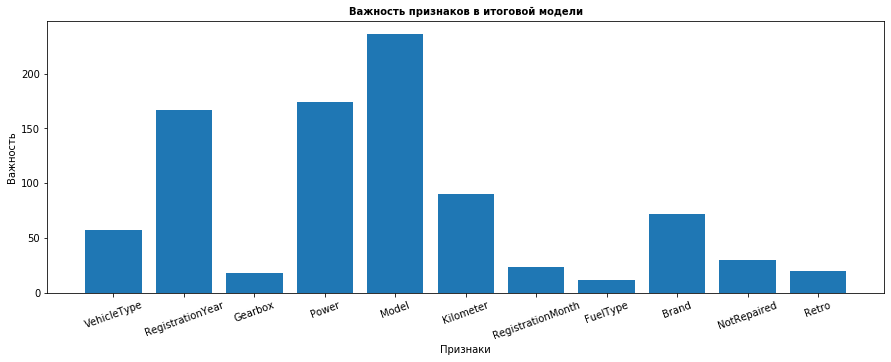

In [84]:
plt.figure(figsize=(15, 5))
plt.title("Важность признаков в итоговой модели", fontweight='bold', size='medium')

plt.ylabel("Важность")
plt.xlabel("Признаки")
plt.xticks(range(11), columns, rotation=20, size='medium')
plt.bar(
    range(len(model_lgbm_best.feature_importances_)),
    model_lgbm_best.feature_importances_)
plt.show()

Видим, что наибольший вклад внесли признаки: Модель, Мощность и Год регистрации. 

## Вывод

<b>Краткие выводы проекта:</b>
- Для корректной работы приложения и модели необходимо внедрить <b>заглушку</b> на ввод неправдоподобных данных: года регистрации автомобиля до 1888 и после текущего года, мощность автомобиля ограничить максимальной до 1000 л.c. А по умолчанию, к примеру, ставить медианное значение 105.
- Также при обработке данных мы заменили редко встречающиеся модели на Other, при работе приложения нужно также повторять эту операцию. А именно запомнить варианты моделей, которые были в этом обучающем датасете и если вариант не из него - заменять на Other перед предсказанием. При переобучении модели - список должен обновляться.


- Для предсказания использовались 3 модели: Линейная регрессия, LGBMRegressor, CatBoostRegressor.

- Все модели, которые мы рассматривали, показали результаты по RMSE лучше, чем элементарные (среднее и медиана).
- CatBoostRegressor ведет себя на порядок хуже по RMSE, чем другие модели. А линейная регресиия вевет себя хуже, чем LGBMRegressor.
- Лучше всего себя показывает модель LGBMRegressor. С гиперпараметрами максимальная глубина дерева - 20 и количеством деревьев 30, и скоростью обучения 1.0. Скорость предсказания у всех моделей несущественная. По времени обучения больше всего у CatBoostRegressor. У LGBMRegressor занчительно меньше, поэтому точно останавливаемся на ней.

| N |       Model                | RMSE  | Время обучения | Скорость предсказания на 82 тыс строк |  
|---|----------------------------|------------|----------|----------|
| 1 | Median |   4822.90  | Меньше 1 сек    | Меньше 1 сек    |
| 2 | Mean |   4517.31  | Меньше 1 сек    | Меньше 1 сек    |
| 3 | LinearRegression |   2350.96  | Около 2 мин    | Меньше 1 сек    |
| 4 | <b>LGBMRegressor</b>  |   1796.20 | Около 2-3 мин    | Меньше 1 сек    |
| 5 | CatBoostRegressor  |   2706.15  | Около 8 мин    | Меньше 1 сек    |

- На тесте оценка итоговой модели <b>LGBMRegressor</b> оказалась 1782.79, что близко к оценке при обучении.

- Наибольший вклад в обучении модели внесли признаки: Модель, Мощность и Год регистрации. 

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей